# Séries Temporais - Multivariada - Água Bruta/Chuva/Temperatura Máx/Temperatura Mín/Umidade Relativa

In [0]:
# !pip install scipy==1.2  --user
# !pip install --upgrade Cython
# !pip install --upgrade git+https://github.com/statsmodels/statsmodels

##Montagem do Drive e Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

plt.rcParams['figure.figsize'] = [40, 30]

%matplotlib inline

sns.set(style="darkgrid")
import seaborn as sns

sns.set(rc={'figure.figsize':(20,8)})

from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


##Tratamento dos Dados

###Dados de Água Bruta

In [2]:
#Drive João
# df_vazao_agua_hora = pd.read_excel('gdrive/My Drive/projetos/lm/Dados_apurados.xlsx', 'vazoes_agua_hora', parse_dates=True, na_values='Null', keep_default_na=False)


#Drive Bruno
df_vazao_agua_hora = pd.read_excel('gdrive/My Drive/Material BSI/LM/Projeto_LM/Dados_apurados.xlsx', 'vazoes_agua_hora')

#Padronização das datas
df_vazao_agua_hora['Data'] = pd.to_datetime(df_vazao_agua_hora['Data'])
df_vazao_agua_hora['Data_dia'] = df_vazao_agua_hora['Data'].map(lambda x: x.strftime('%Y-%m-%d'))

#Tratamento Geral
df_vazao_agua_hora['agua_bruta_m3/h'] = df_vazao_agua_hora['agua_bruta_m3/h'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float).dropna()

#Agrupamento dos dados de horários para diários
df_volume_agua_dia = df_vazao_agua_hora.groupby('Data_dia')

#Totalização das vazões horárias em VOLUME DIÁRIO
df_volume_agua_dia = df_volume_agua_dia.aggregate(np.sum)
df_volume_agua_dia = df_volume_agua_dia.rename(columns={'agua_bruta_m3/h': 'agua_bruta_m3'})


print(df_volume_agua_dia.dtypes)
df_volume_agua_dia.head()

agua_bruta_m3    float64
dtype: object


,agua_bruta_m3
Data_dia,
2015-01-01,9449.860189
2015-01-02,14190.898285
2015-01-03,14592.745667
2015-01-04,10225.120845
2015-01-05,8463.903225


###Dados Metereológicos

In [3]:
#Drive João
# df_tempo = pd.read_excel('gdrive/My Drive/projetos/lm/Dados_apurados.xlsx', 'dados_tempo_diarios')

#Drive Bruno
df_tempo = pd.read_excel('gdrive/My Drive/Material BSI/LM/Projeto_LM/Dados_apurados.xlsx', 'dados_tempo_diarios')

#Padronização das datas
df_tempo = df_tempo.rename(columns={'Dia': 'Data_dia'})
df_tempo['Data_dia'] = df_tempo['Data_dia'].map(lambda x: x.strftime('%Y-%m-%d'))

print(df_tempo.dtypes)
df_tempo.head()
#print(df)

Data_dia                   object
Chuva                     float64
TempMaxima                float64
TempMinima                float64
Umidade Relativa Media    float64
dtype: object


,Data_dia,Chuva,TempMaxima,TempMinima,Umidade Relativa Media
0,2015-01-01,0.0,28.4,23.0,88.75
1,2015-01-02,37.0,30.2,23.0,75.25
2,2015-01-03,0.0,30.8,20.8,72.25
3,2015-01-04,0.0,31.4,20.4,67.50
4,2015-01-05,0.0,32.0,22.2,69.50


####Preenchendo dados ausentes

In [4]:
df_tempo.isnull().sum()

Data_dia                   0
Chuva                      0
TempMaxima                 2
TempMinima                 3
Umidade Relativa Media    10
dtype: int64

In [5]:
#Acrescentando valores médios nos dados ausentes
TempMaxMedia = df_tempo['TempMaxima'].mean()
TempMaxMedia = round(TempMaxMedia, 1)
df_tempo.update(df_tempo['TempMaxima'].fillna(TempMaxMedia))

TempMinMedia = df_tempo['TempMinima'].mean()
TempMinMedia = round(TempMinMedia, 1)
df_tempo.update(df_tempo['TempMinima'].fillna(TempMinMedia))

UmidMedia = df_tempo['Umidade Relativa Media'].mean()
UmidMedia = round(UmidMedia, 2)
df_tempo.update(df_tempo['Umidade Relativa Media'].fillna(UmidMedia))

df_tempo.isnull().sum()

Data_dia                  0
Chuva                     0
TempMaxima                0
TempMinima                0
Umidade Relativa Media    0
dtype: int64

###Junção dos Dados

In [6]:
df_agua_tempo = pd.merge(df_volume_agua_dia, df_tempo, on='Data_dia')

#Reconvertendo Data_dia para DateTime
df_agua_tempo['Data_dia'] = pd.to_datetime(df_agua_tempo['Data_dia'])

print(df_agua_tempo.dtypes)
df_agua_tempo.head()

Data_dia                  datetime64[ns]
agua_bruta_m3                    float64
Chuva                            float64
TempMaxima                       float64
TempMinima                       float64
Umidade Relativa Media           float64
dtype: object


,Data_dia,agua_bruta_m3,Chuva,TempMaxima,TempMinima,Umidade Relativa Media
0,2015-01-01,9449.860189,0.0,28.4,23.0,88.75
1,2015-01-02,14190.898285,37.0,30.2,23.0,75.25
2,2015-01-03,14592.745667,0.0,30.8,20.8,72.25
3,2015-01-04,10225.120845,0.0,31.4,20.4,67.50
4,2015-01-05,8463.903225,0.0,32.0,22.2,69.50


###Plotando Dados

<Figure size 576x360 with 0 Axes>

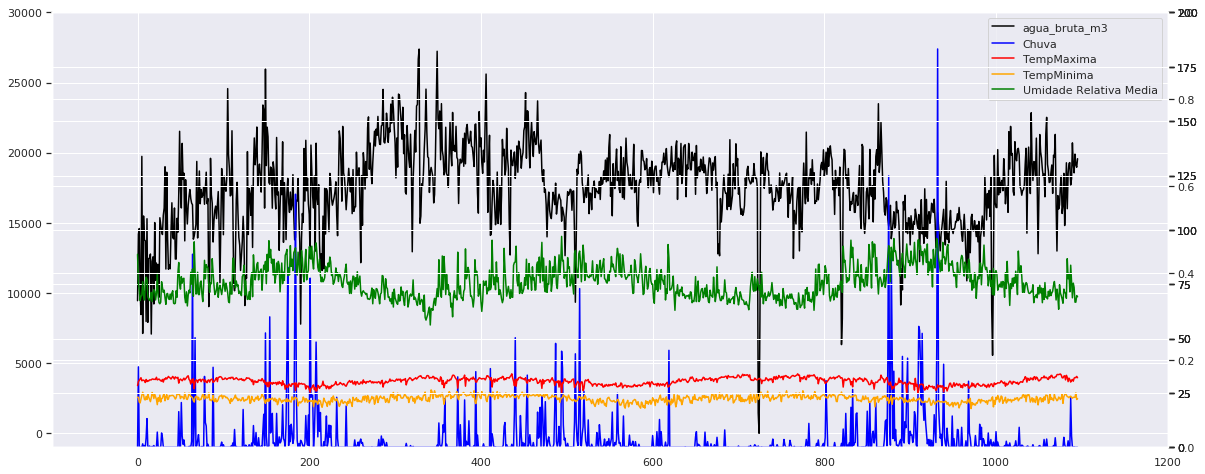

In [7]:
fig = plt.figure(figsize=(8, 5))

fig, host = plt.subplots()

ax1 = host.twinx()
ax2 = host.twinx()
ax3 = host.twinx()
ax4 = host.twinx()
ax5 = host.twinx()


p1, = host.plot(df_agua_tempo['agua_bruta_m3'], color='black')
p2, = ax1.plot(df_agua_tempo['Chuva'], color='blue')
p3, = ax2.plot(df_agua_tempo['TempMaxima'], color='red')
p4, = ax3.plot(df_agua_tempo['TempMinima'], color='orange')
p5, = ax4.plot(df_agua_tempo['Umidade Relativa Media'], color='green')

host.set_xlim(-100, 1200)
host.set_ylim(-1000, 30000)
ax1.set_ylim(0, 200)
ax2.set_ylim(0, 200)
ax3.set_ylim(0, 200)
ax4.set_ylim(0, 200)


lines = [p1, p2, p3, p4, p5]

host.legend(lines, [l.get_label() for l in lines])

plt.show()

##Teste Dick Fuller
**Return**

**adf**:float (Test statistic)

**pvalue**:float
(MacKinnon’s approximate p-value based on MacKinnon (1994, 2010))

**usedlag**:int
(Number of lags used)

**nobs**:int
(Number of observations used for the ADF regression and calculation of the critical values)

**critical values**:dict
(Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010))

**icbest**:float
(The maximized information criterion if autolag is not None.)

**resstore**: ResultStore, optional
(A dummy class with results attached as attributes)

###Teste variáveis sem diferenciação

In [8]:
print('Resultados de Água Bruta')
print(sm.tsa.stattools.adfuller(df_agua_tempo['agua_bruta_m3']),'\n')

print('Resultados de Chuva')
print(sm.tsa.stattools.adfuller(df_agua_tempo['Chuva']),'\n')

print('Resultados de TempMaxima')
print(sm.tsa.stattools.adfuller(df_agua_tempo['TempMaxima']),'\n')

print('Resultados de TempMinima')
print(sm.tsa.stattools.adfuller(df_agua_tempo['TempMinima']),'\n')

print('Resultados de UmidMedia')
print(sm.tsa.stattools.adfuller(df_agua_tempo['Umidade Relativa Media']))

Resultados de Água Bruta
(-4.9166335756198665, 3.2365585396321904e-05, 9, 1086, {'1%': -3.4363857496063455, '5%': -2.8642050392821794, '10%': -2.5681889563132314}, 19501.51516556401) 

Resultados de Chuva
(-3.9001759184771396, 0.0020335528245859886, 20, 1075, {'1%': -3.4364476591811033, '5%': -2.864232347211692, '10%': -2.5682035004867494}, 8305.257644110083) 

Resultados de TempMaxima
(-1.9492664987088821, 0.3092510221381819, 20, 1075, {'1%': -3.4364476591811033, '5%': -2.864232347211692, '10%': -2.5682035004867494}, 2895.8303004756335) 

Resultados de TempMinima
(-2.8381261139888494, 0.05303071636227612, 15, 1080, {'1%': -3.436419361753321, '5%': -2.864219865461312, '10%': -2.5681968527091907}, 3281.8750292536547) 

Resultados de UmidMedia
(-2.384868682790192, 0.14605273296662613, 20, 1075, {'1%': -3.4364476591811033, '5%': -2.864232347211692, '10%': -2.5682035004867494}, 6561.606001761516)


###Aplicando diferenciação (Temperaturas Máxima, Mínima e Umidade Relativa Média)

In [9]:
df_agua_tempo['TempMaxima_diff']=df_agua_tempo['TempMaxima'].diff()
df_agua_tempo['TempMinima_diff']=df_agua_tempo['TempMinima'].diff()
df_agua_tempo['UmidRelatMedia_diff']=df_agua_tempo['Umidade Relativa Media'].diff()

#Acrescentando valores médios nos dados ausentes
TempMaxMediaD = df_agua_tempo['TempMaxima_diff'].mean()
TempMaxMediaD = round(TempMaxMediaD, 1)
df_agua_tempo.update(df_agua_tempo['TempMaxima_diff'].fillna(TempMaxMediaD))

TempMinMediaD = df_agua_tempo['TempMinima_diff'].mean()
TempMinMediaD = round(TempMinMediaD, 1)
df_agua_tempo.update(df_agua_tempo['TempMinima_diff'].fillna(TempMinMediaD))

UmidMediaD = df_agua_tempo['UmidRelatMedia_diff'].mean()
UmidMediaD = round(UmidMediaD, 2)
df_agua_tempo.update(df_agua_tempo['UmidRelatMedia_diff'].fillna(UmidMediaD))

df_agua_tempo.isna().sum()

Data_dia                  0
agua_bruta_m3             0
Chuva                     0
TempMaxima                0
TempMinima                0
Umidade Relativa Media    0
TempMaxima_diff           0
TempMinima_diff           0
UmidRelatMedia_diff       0
dtype: int64

###Teste variáveis com diferenciação

In [10]:
print('Resultados de TempMaximaDiff')
print(sm.tsa.stattools.adfuller(df_agua_tempo['TempMaxima_diff']),'\n')

print('Resultados de TempMinimaDiff')
print(sm.tsa.stattools.adfuller(df_agua_tempo['TempMinima_diff']),'\n')

print('Resultados de UmidMediaDiff')
print(sm.tsa.stattools.adfuller(df_agua_tempo['UmidRelatMedia_diff']))

Resultados de TempMaximaDiff
(-11.57576557618353, 3.0254531191685056e-21, 19, 1076, {'1%': -3.436441978605957, '5%': -2.864229841568573, '10%': -2.5682021659802934}, 2897.7713696721103) 

Resultados de TempMinimaDiff
(-11.478681428089734, 5.056843530340475e-21, 19, 1076, {'1%': -3.436441978605957, '5%': -2.864229841568573, '10%': -2.5682021659802934}, 3287.5364733671977) 

Resultados de UmidMediaDiff
(-12.333296680035408, 6.355148817603613e-23, 19, 1076, {'1%': -3.436441978605957, '5%': -2.864229841568573, '10%': -2.5682021659802934}, 6565.474849414404)


##OLS Regression

###Mantendo as variáveis não-estacionárias (maior precisão)

In [12]:
df_agua_tempo['const'] = 1
y = df_agua_tempo['agua_bruta_m3']
x = df_agua_tempo[['Chuva','TempMaxima','TempMinima','Umidade Relativa Media','const']]
res = sm.OLS(y, x).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          agua_bruta_m3   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     14.60
Date:                Mon, 01 Jul 2019   Prob (F-statistic):           1.28e-11
Time:                        12:41:48   Log-Likelihood:                -10284.
No. Observations:                1096   AIC:                         2.058e+04
Df Residuals:                    1091   BIC:                         2.060e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Chuva                    -10

In [13]:
print('Parameters: ', res.params)
print('Standard errors: ', res.bse)
print('Predicted values: ', res.predict())

Parameters:  Chuva                       -10.048020
TempMaxima                  -76.451755
TempMinima                  217.141656
Umidade Relativa Media      -71.665403
const                     20433.923549
dtype: float64
Standard errors:  Chuva                        7.844890
TempMaxima                  83.249514
TempMinima                  66.917337
Umidade Relativa Media      17.613123
const                     3430.834561
dtype: float64
Predicted values:  [16896.64730086 17354.74032091 17417.93058871 ... 18632.34315103
 17720.05092272 17888.61133949]


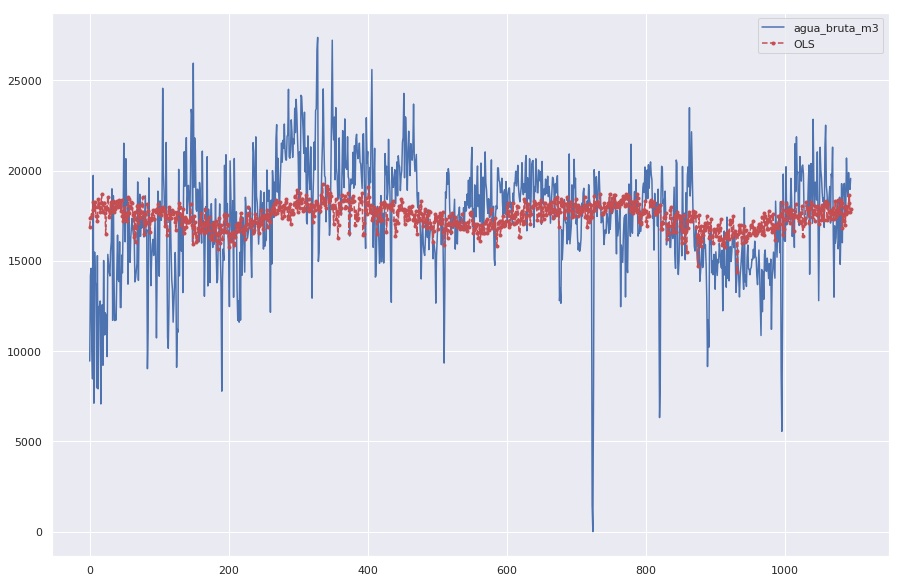

In [14]:
prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots(figsize=(15,10))

ax.plot(y, label="agua_bruta_m3")
ax.plot(res.fittedvalues, 'r--.', label="OLS")
ax.legend(loc='best');

###Teste com as variáveis estacionárias (menor precisão)

In [16]:
y2 = df_agua_tempo['agua_bruta_m3']
x2 = df_agua_tempo[['Chuva','TempMaxima_diff','TempMinima_diff','UmidRelatMedia_diff','const']]
res2 = sm.OLS(y2, x2).fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:          agua_bruta_m3   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.387
Date:                Mon, 01 Jul 2019   Prob (F-statistic):            0.00917
Time:                        12:42:23   Log-Likelihood:                -10305.
No. Observations:                1096   AIC:                         2.062e+04
Df Residuals:                    1091   BIC:                         2.065e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Chuva                 -25.9439    

In [17]:
print('Parameters: ', res2.params)
print('Standard errors: ', res2.bse)
print('Predicted values: ', res2.predict())

Parameters:  Chuva                    -25.943929
TempMaxima_diff           34.272210
TempMinima_diff          -19.567642
UmidRelatMedia_diff        2.391252
const                  17577.287097
dtype: float64
Standard errors:  Chuva                   7.215709
TempMaxima_diff        96.271389
TempMinima_diff        65.125126
UmidRelatMedia_diff    17.084607
const                  93.747147
dtype: float64
Predicted values:  [17577.23927223 16646.76980109 17633.72548004 ... 17534.72459295
 17663.72710334 17547.70108864]


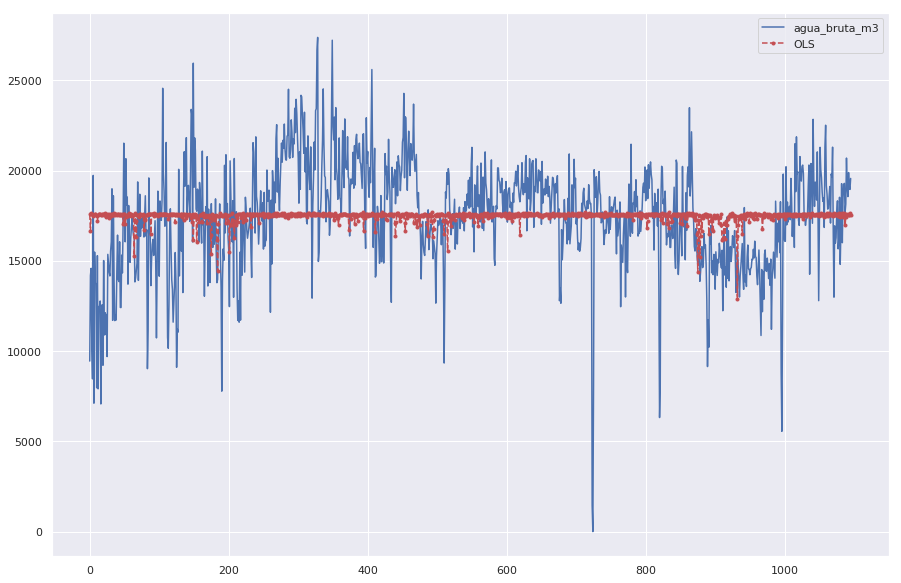

In [18]:
prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax2 = plt.subplots(figsize=(15,10))

ax2.plot(y2, label="agua_bruta_m3")
ax2.plot(res2.fittedvalues, 'r--.', label="OLS")
ax2.legend(loc='best');

##Teste Causalidade de Granger

###Influência da chuva no consumo da água bruta

In [0]:
print(sm.tsa.stattools.grangercausalitytests(df_agua_tempo[['agua_bruta_m3','Chuva']].dropna(), 1, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6861  , p=0.1944  , df_denom=1092, df_num=1
ssr based chi2 test:   chi2=1.6907  , p=0.1935  , df=1
likelihood ratio test: chi2=1.6894  , p=0.1937  , df=1
parameter F test:         F=1.6861  , p=0.1944  , df_denom=1092, df_num=1
{1: ({'ssr_ftest': (1.6860858281853544, 0.19439189494165346, 1092.0, 1), 'ssr_chi2test': (1.6907179321089407, 0.19350635695967944, 1), 'lrtest': (1.6894140106087434, 0.19367823347719876, 1), 'params_ftest': (1.6860858281846751, 0.19439189494170958, 1092.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f89797e0320>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f897977c748>, array([[0., 1., 0.]])])}


###Influência da temperatura máxima no consumo da água bruta

In [0]:
print(sm.tsa.stattools.grangercausalitytests(df_agua_tempo[['agua_bruta_m3','TempMaxima_diff']].dropna(), 1, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1388  , p=0.7095  , df_denom=1092, df_num=1
ssr based chi2 test:   chi2=0.1392  , p=0.7091  , df=1
likelihood ratio test: chi2=0.1392  , p=0.7091  , df=1
parameter F test:         F=0.1388  , p=0.7095  , df_denom=1092, df_num=1
{1: ({'ssr_ftest': (0.13884307432410897, 0.7095061790869481, 1092.0, 1), 'ssr_chi2test': (0.1392245113414829, 0.709053173159329, 1), 'lrtest': (0.13921566119825002, 0.7090619994486335, 1), 'params_ftest': (0.13884307432406778, 0.7095061790869481, 1092.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f897940f6d8>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f8978f7e9e8>, array([[0., 1., 0.]])])}


###Influência da temperatura mínima no consumo da água bruta

In [0]:
print(sm.tsa.stattools.grangercausalitytests(df_agua_tempo[['agua_bruta_m3','TempMinima_diff']].dropna(), 1, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1562  , p=0.6928  , df_denom=1092, df_num=1
ssr based chi2 test:   chi2=0.1566  , p=0.6923  , df=1
likelihood ratio test: chi2=0.1566  , p=0.6923  , df=1
parameter F test:         F=0.1562  , p=0.6928  , df_denom=1092, df_num=1
{1: ({'ssr_ftest': (0.15617740557055912, 0.6927777361345897, 1092.0, 1), 'ssr_chi2test': (0.15660646437707165, 0.69230027707297, 1), 'lrtest': (0.15659526654781075, 0.6923107156519713, 1), 'params_ftest': (0.15617740557074458, 0.6927777361343633, 1092.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f8979931fd0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f8979523c88>, array([[0., 1., 0.]])])}


###Influência da umidade relativa média no consumo da água bruta

In [0]:
print(sm.tsa.stattools.grangercausalitytests(df_agua_tempo[['agua_bruta_m3','UmidRelatMedia_diff']].dropna(), 1, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1882  , p=0.6645  , df_denom=1092, df_num=1
ssr based chi2 test:   chi2=0.1887  , p=0.6640  , df=1
likelihood ratio test: chi2=0.1887  , p=0.6640  , df=1
parameter F test:         F=0.1882  , p=0.6645  , df_denom=1092, df_num=1
{1: ({'ssr_ftest': (0.18820663592658168, 0.6644991208844334, 1092.0, 1), 'ssr_chi2test': (0.1887236871241822, 0.6639810111777459, 1), 'lrtest': (0.18870742569197319, 0.663994600129151, 1), 'params_ftest': (0.1882066359265648, 0.6644991208846363, 1092.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f897940fac8>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f897900cc50>, array([[0., 1., 0.]])])}


###Aplicação ARIMA 

####**Água Bruta x Chuva**

In [0]:
df_agua_tempo['lagCHU']=df_agua_tempo['Chuva'].shift()

df_agua_tempo.dropna(inplace=True)
model3=sm.tsa.ARIMA(endog=df_agua_tempo['agua_bruta_m3'],exog=df_agua_tempo[['lagCHU']],order=[1,1,0])
results3=model3.fit()
print(results3.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.agua_bruta_m3   No. Observations:                 1094
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -10063.568
Method:                       css-mle   S.D. of innovations           2391.986
Date:                Sun, 30 Jun 2019   AIC                          20135.136
Time:                        14:23:01   BIC                          20155.126
Sample:                             1   HQIC                         20142.700
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -8.2592     57.990     -0.142      0.887    -121.918     105.400
lagCHU                    3.0875      5.075      0.608      0.543      -6.859      13.034
ar.L1.D.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
print('Parameters: ', results3.params)
print('Standard errors: ', results3.bse)
print('Predicted values: ', results3.predict())

Parameters:  const                   -8.259153
lagCHU                   3.087493
ar.L1.D.agua_bruta_m3   -0.339302
dtype: float64
Standard errors:  const                    57.990300
lagCHU                    5.074606
ar.L1.D.agua_bruta_m3     0.028422
dtype: float64
Predicted values:  2        105.978089
3       -108.648259
4       1470.883278
5        586.523539
6      -3836.350013
7       4276.360272
8      -2850.373462
9        573.376281
10         6.206161
11      1955.724812
12     -2450.391246
13      2507.339479
14     -1553.750472
15       -19.975125
16      -108.526813
17      1924.733338
18     -1768.484650
19      -119.036165
20      1130.791029
21     -1979.411483
22      1388.627258
23      -430.907111
24       422.324914
25      -382.606980
26       782.309597
27     -1933.442396
28       160.223068
29       171.740673
30        81.559148
31      -472.237862
           ...     
1066    -190.986887
1067     676.138123
1068    -930.425283
1069      39.892022
1070    -552.

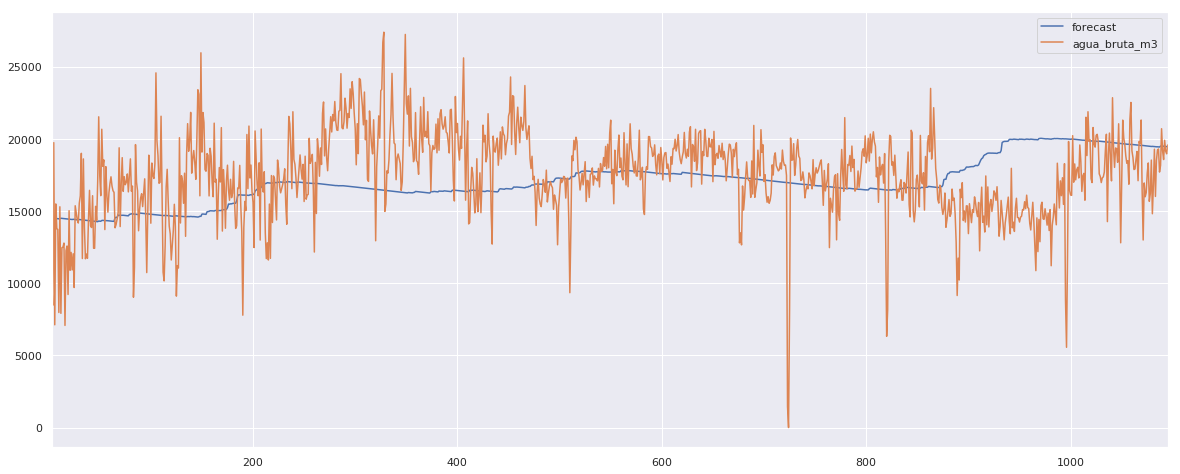

In [0]:
fig = results3.plot_predict(dynamic=True, plot_insample=True, alpha=0.05)
plt.show()

####**Água Bruta x Temperatura Máxima**

In [0]:
df_agua_tempo['lagTempMax']=df_agua_tempo['TempMaxima_diff'].shift()

df_agua_tempo.dropna(inplace=True)
model4=sm.tsa.ARIMA(endog=df_agua_tempo['agua_bruta_m3'],exog=df_agua_tempo[['lagTempMax']],order=[1,1,0])
results4=model4.fit()
print(results4.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:        D.agua_bruta_m3   No. Observations:                 1093
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -10054.884
Method:                       css-mle   S.D. of innovations           2393.113
Date:                Sun, 30 Jun 2019   AIC                          20117.768
Time:                        14:24:07   BIC                          20137.755
Sample:                             1   HQIC                         20125.332
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.1214     54.024      0.095      0.924    -100.764     111.007
lagTempMax              -25.9110     73.667     -0.352      0.725    -170.295     118.473
ar.L1.D.

In [0]:
print('Parameters: ', results4.params)
print('Standard errors: ', results4.bse)
print('Predicted values: ', results4.predict())

Parameters:  const                     5.121447
lagTempMax              -25.911014
ar.L1.D.agua_bruta_m3    -0.340191
dtype: float64
Standard errors:  const                    54.024319
lagTempMax               73.666589
ar.L1.D.agua_bruta_m3     0.028486
dtype: float64
Predicted values:  3        -10.425162
4       1471.853115
5        585.177939
6      -3797.453587
7       4307.716279
8      -2845.916730
9        597.247051
10        46.709535
11      1935.955273
12     -2470.765335
13      2513.853132
14     -1539.089475
15       -15.123163
16       -95.894324
17      1947.726867
18     -1766.763369
19      -105.339656
20      1154.411594
21     -1968.308249
22      1411.926783
23      -439.110683
24       441.994323
25      -367.611483
26       795.366884
27     -1911.948903
28       192.487021
29       178.421772
30        60.208235
31      -436.719225
32      -193.598172
           ...     
1066    -185.820006
1067     723.483218
1068    -910.278564
1069      61.411110
1070    -5

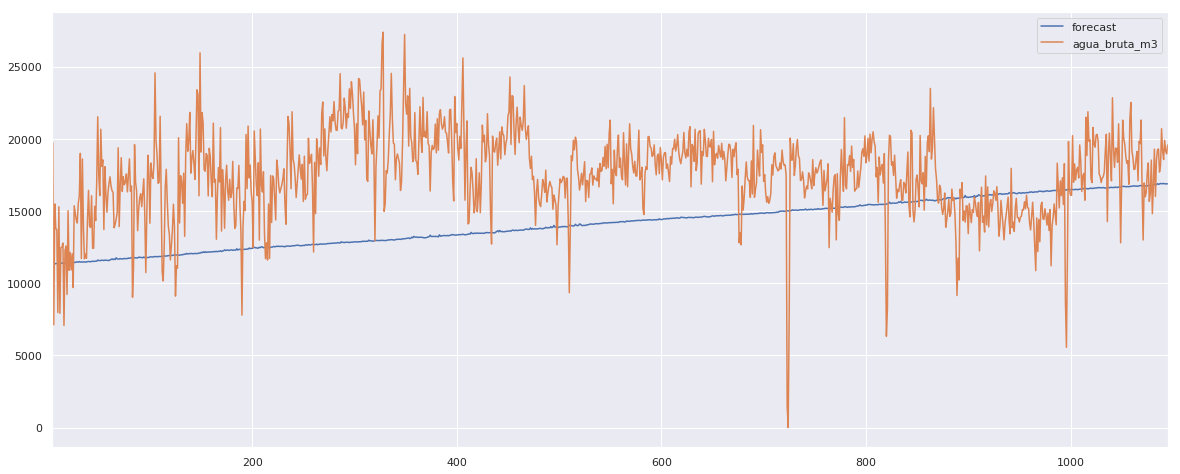

In [0]:
fig = results4.plot_predict(dynamic=True, plot_insample=True, alpha=0.05)
plt.show()

####**Água Bruta x Temperatura Mínima**

In [0]:
df_agua_tempo['lagTempMin']=df_agua_tempo['TempMinima_diff'].shift()

df_agua_tempo.dropna(inplace=True)
model5=sm.tsa.ARIMA(endog=df_agua_tempo['agua_bruta_m3'],exog=df_agua_tempo[['lagTempMin']],order=[1,1,0])
results5=model5.fit()
print(results5.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.agua_bruta_m3   No. Observations:                 1092
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -10043.935
Method:                       css-mle   S.D. of innovations           2389.279
Date:                Sun, 30 Jun 2019   AIC                          20095.869
Time:                        14:24:37   BIC                          20115.852
Sample:                             1   HQIC                         20103.432
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.7844     53.923      0.163      0.871     -96.903     114.472
lagTempMin               30.6791     56.092      0.547      0.585     -79.260     140.618
ar.L1.D.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
print('Parameters: ', results5.params)
print('Standard errors: ', results5.bse)
print('Predicted values: ', results5.predict())

Parameters:  const                     8.784427
lagTempMin               30.679123
ar.L1.D.agua_bruta_m3    -0.341160
dtype: float64
Standard errors:  const                    53.923372
lagTempMin               56.092180
ar.L1.D.agua_bruta_m3     0.028436
dtype: float64
Predicted values:  4         -3.487222
5        663.674241
6      -3763.458210
7       4378.455470
8      -2863.856451
9        517.928441
10        -0.861235
11      2022.670641
12     -2512.721968
13      2589.044567
14     -1557.185773
15       -44.375957
16      -127.995268
17      2002.931459
18     -1664.036706
19       -96.629603
20      1087.671063
21     -1927.763680
22      1403.252056
23      -459.737871
24       339.620254
25      -296.118229
26       793.902668
27     -1851.970332
28       115.136735
29       190.689218
30       107.179997
31      -412.131649
32      -136.556068
33     -1079.222595
           ...     
1066    -174.866728
1067     688.594839
1068    -937.766022
1069     142.839475
1070    -5

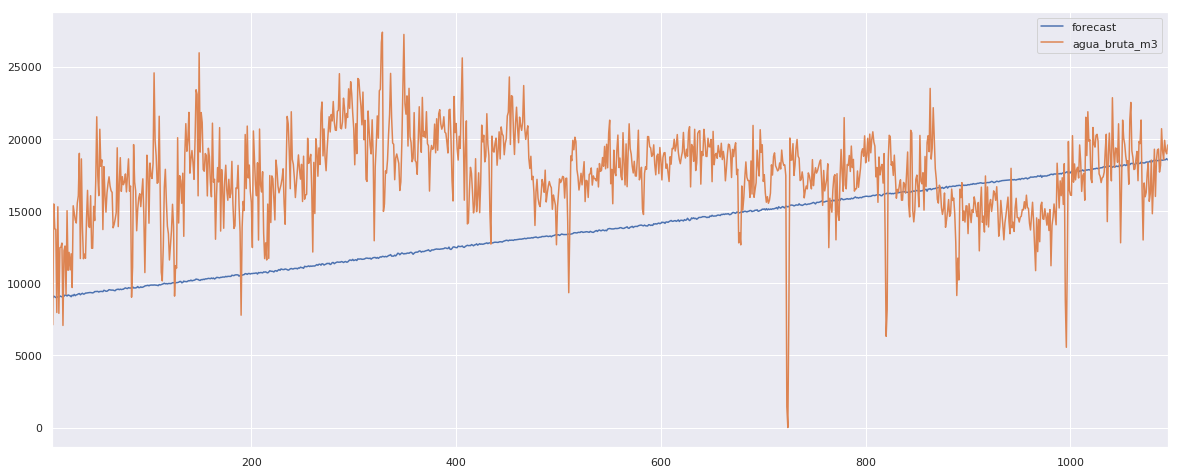

In [0]:
fig = results5.plot_predict(dynamic=True, plot_insample=True, alpha=0.05)
plt.show()

####**Água Bruta x Umidade Relativa Média**


In [0]:
df_agua_tempo['lagUmid']=df_agua_tempo['UmidRelatMedia_diff'].shift()

df_agua_tempo.dropna(inplace=True)
model6=sm.tsa.ARIMA(endog=df_agua_tempo['agua_bruta_m3'],exog=df_agua_tempo[['lagUmid']],order=[1,1,0])
results6=model6.fit()
print(results6.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.agua_bruta_m3   No. Observations:                 1091
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -10034.650
Method:                       css-mle   S.D. of innovations           2389.086
Date:                Sun, 30 Jun 2019   AIC                          20077.300
Time:                        14:24:54   BIC                          20097.280
Sample:                             1   HQIC                         20084.862
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     7.5041     53.778      0.140      0.889     -97.899     112.907
lagUmid                 -10.8174     12.843     -0.842      0.400     -35.988      14.354
ar.L1.D.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
print('Parameters: ', results6.params)
print('Standard errors: ', results6.bse)
print('Predicted values: ', results6.predict())

Parameters:  const                     7.504133
lagUmid                 -10.817426
ar.L1.D.agua_bruta_m3    -0.345298
dtype: float64
Standard errors:  const                    53.778087
lagUmid                  12.842558
ar.L1.D.agua_bruta_m3     0.028711
dtype: float64
Predicted values:  5        -14.130718
6      -3892.968431
7       4298.307984
8      -2841.323030
9        651.354376
10       -47.681723
11      1939.117532
12     -2517.962684
13      2649.203429
14     -1519.156684
15        10.987229
16       -97.748077
17      1946.616285
18     -1743.939649
19      -130.313225
20      1140.216419
21     -1990.448169
22      1480.590449
23      -434.681130
24       317.879212
25      -299.151213
26       890.929665
27     -1928.709612
28       178.161354
29        71.121499
30        76.904679
31      -430.387348
32      -169.705911
33      -971.100436
34      2572.562715
           ...     
1066    -176.259597
1067     696.656976
1068    -960.578447
1069      31.893982
1070    -5

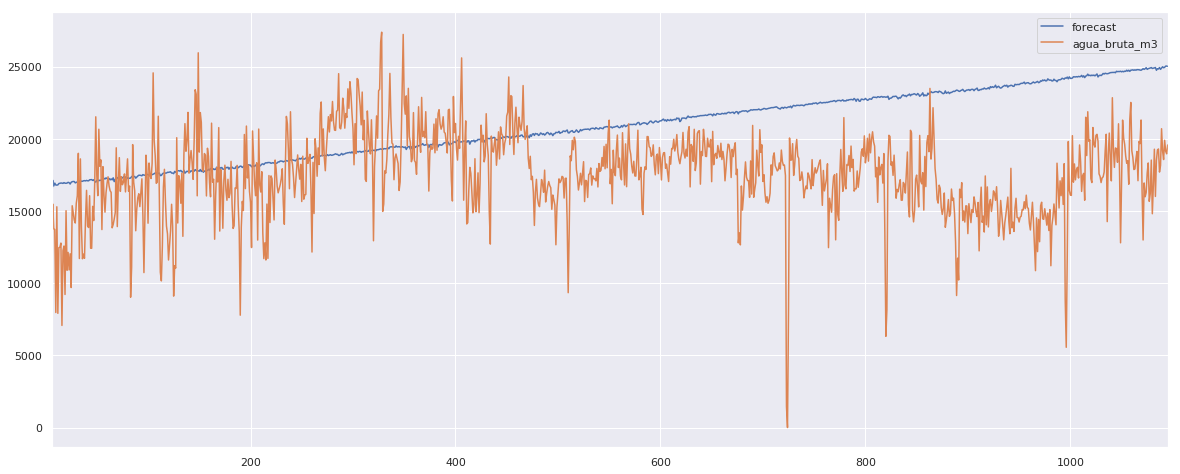

In [0]:
fig = results6.plot_predict(dynamic=True, plot_insample=True, alpha=0.05)
plt.show()